In [ ]:
# Cell 1: Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
# Cell 2A: Load local CSV (upload in Colab: Files panel or files.upload())
path = "/content/Mall_Customers.csv"
df = pd.read_csv(path)
df.head(), df.shape, df.isna().sum().sum()


(   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
 0           1    Male   19                  15                      39
 1           2    Male   21                  15                      81
 2           3  Female   20                  16                       6
 3           4  Female   23                  16                      77
 4           5  Female   31                  17                      40,
 (200, 5),
 np.int64(0))

In [ ]:
# Cell 3: Basic cleaning & split features/target
# If there is a known target column, set it here; else set target_col=None
target_col = "class" if "class" in df.columns else None

# Keep only numeric columns for PCA
num_df = df.select_dtypes(include=[np.number]).copy()

# Drop rows with missing numeric values (simple strategy; can impute instead)
num_df = num_df.dropna(axis=0)

if target_col and target_col in num_df.columns:
    X = num_df.drop(columns=[target_col]).values
    y = num_df[target_col].values
else:
    X = num_df.values
    y = None

X.shape, (None if y is None else len(y))


((200, 4), None)

In [ ]:
# Cell 4: Train-test split (only if classification target exists)
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None
    )
else:
    # Unsupervised case: use all data for PCA demo
    X_train, X_test, y_train, y_test = X, None, None, None
X_train.shape


(200, 4)

In [ ]:
# Cell 5: Standardize (fit on train)
scaler = StandardScaler()
if y is not None:
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
else:
    X_train_s = scaler.fit_transform(X)
    X_test_s  = None

X_train_s[:3]


array([[-1.7234121 , -1.42456879, -1.73899919, -0.43480148],
       [-1.70609137, -1.28103541, -1.73899919,  1.19570407],
       [-1.68877065, -1.3528021 , -1.70082976, -1.71591298]])

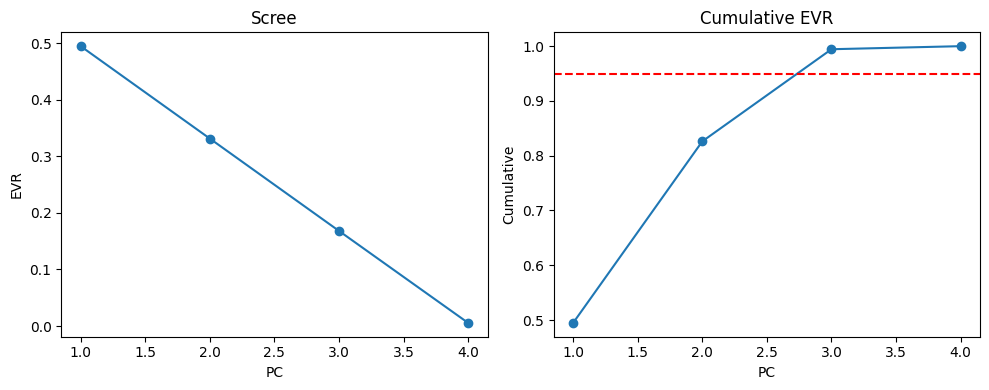

(np.int64(3), np.int64(3))

In [ ]:
# Cell 6: Determine components via scree & cumulative variance
pca_full = PCA(n_components=min(X_train_s.shape), random_state=42)
pca_full.fit(X_train_s)

evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(range(1,len(evr)+1), evr, marker='o'); plt.title("Scree"); plt.xlabel("PC"); plt.ylabel("EVR")
plt.subplot(1,2,2); plt.plot(range(1,len(cum)+1), cum, marker='o'); plt.axhline(0.95, ls='--', c='r'); plt.title("Cumulative EVR"); plt.xlabel("PC"); plt.ylabel("Cumulative")
plt.tight_layout(); plt.show()

k95 = np.searchsorted(cum, 0.95) + 1
k90 = np.searchsorted(cum, 0.90) + 1
k95, k90


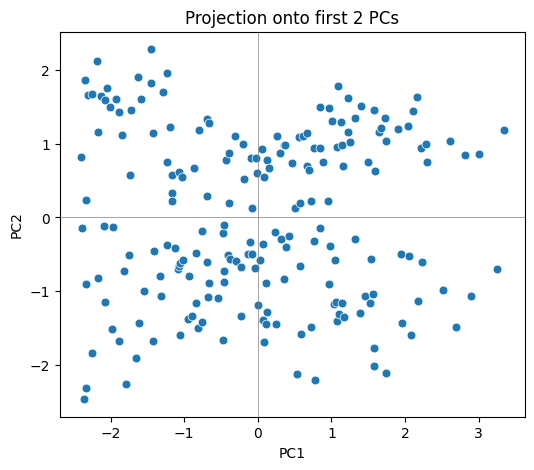

np.float64(0.8262212698712086)

In [ ]:
# Cell 7: Reduce to 2 PCs for visualization
pca2 = PCA(n_components=2, random_state=42)
Z2 = pca2.fit_transform(X_train_s)
pc_df = pd.DataFrame(Z2, columns=["PC1","PC2"])
if y_train is not None:
    pc_df["target"] = y_train

plt.figure(figsize=(6,5))
if "target" in pc_df:
    sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="target", palette="Set2", s=50)
else:
    sns.scatterplot(data=pc_df, x="PC1", y="PC2", s=40)
plt.title("Projection onto first 2 PCs")
plt.axhline(0,c='gray',lw=0.5); plt.axvline(0,c='gray',lw=0.5)
plt.show()

pca2.explained_variance_ratio_.sum()


In [ ]:
# Cell 8: Reconstruction error (info loss estimate)
Xr_s = pca2.inverse_transform(Z2)
Xr = scaler.inverse_transform(Xr_s)
Xorig = scaler.inverse_transform(X_train_s)
mse = np.mean((Xorig - Xr)**2)
mae = np.mean(np.abs(Xorig - Xr))
mse, mae


(np.float64(83.34770451472161), np.float64(6.078180197694093))

In [1]:
# Cell 5: Pipeline = Standardize -> PCA (95% variance) -> Logistic Regression
# Change n_components to an int (e.g., 2) for fixed PCs, or 0.95 to auto-pick by variance.
if y is not None:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=42)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("PCs used:", pipe.named_steps["pca"].n_components_)



NameError: name 'y' is not defined